# Decision tree for classification

Purpose: use Breast Cancer data set in sklearn and build the decision tree from scratch

In [1]:
%matplotlib inline
import numpy as np

from sklearn import datasets as ds
from sklearn.decomposition import PCA
from sklearn import preprocessing

import matplotlib.pyplot as plt

In [2]:
#get the data
data_all = ds.load_breast_cancer()

x = data_all.data
y = data_all.target

y_names = data_all.target_names 

feature_names = data_all.feature_names 



In [3]:
#get to know the data
print(feature_names)
print(len(feature_names))
print(y)
print(y_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
30
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 

There are 30 features in the data, so the decision tree is good for this data.         

In [4]:
#prepare the data
split = int(x.shape[0] * 0.6)

x_train = x[:split,:]
y_train = y[:split]

x_test = x[split:,:]
y_test = y[split:]

print('Training set size:', x_train.shape[0])
print('Test set size:', x_test.shape[0])

Training set size: 341
Test set size: 228


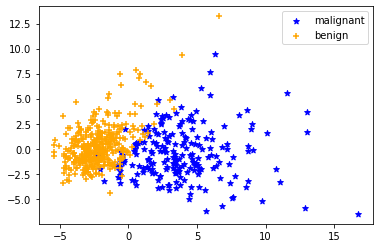

In [5]:
#visualize the data
#since there are 30 features, we need to use a dimension reduction method. Here PCA is used.

pca = PCA(n_components=2)
x_scaled = preprocessing.scale(x[:,:-1]) # We remove the indexing and make sure all the features are in N(0,1)
x_reduced = pca.fit_transform(x_scaled)
# x_reduced = pca.fit_transform(x[:,0:-1]) 


plt.figure()
plt.scatter(x_reduced[:,0][y==0], x_reduced[:,1][y==0], c = 'b' , label = 'malignant', marker='*')
plt.scatter(x_reduced[:,0][y==1], x_reduced[:,1][y==1], c = 'orange' , label = 'benign', marker='+')
plt.legend()
plt.show()



## Decision tree

In [6]:
#calculate the entropy
#entropy = -sum(p_i * log(p_i)), where p_i=probability of selecting class i from the labels
def cal_entropy(labels):
    n_labels=len(labels)
    classes, counts=np.unique(labels, return_counts=True)
    probs=counts/n_labels 
    n_classes=len(classes)
    entropy=0
    for prob in probs:
        entropy=entropy-prob*np.log(prob)
    return entropy

In [17]:
#The function find_split() allows us to find the optimal feature 
#and the best value to split the data into two chunks (on its own it is the decision stump algorithm). 
#Applying this to the original data set splits it into two new data sets.
def find_split(x, y):
    """Given a dataset and its target values, this finds the optimal combination
    of feature and split point that gives the maximum information gain."""
    
    # Need the starting entropy so we can measure improvement...
    start_entropy = cal_entropy(y)
    
    # Best thus far, initialised to a dud that will be replaced immediately...
    best = {'infogain' : -np.inf}
    
    # Loop every possible split of every dimension...
    for i in range(x.shape[1]):
        #split: threshold for feature i
        for split in np.unique(x[:,i]):
            left_indices = []
            right_indices = []
            
            for index in range(x.shape[0]):
                if x[index, i]>split:                      
                    right_indices.append(index)            
                else:
                    left_indices.append(index)             
            
            nl = float(len(left_indices))                  
            nr = float(len(right_indices))
            n = nl + nr                                    
            
            infogain = start_entropy - (nl/n)*cal_entropy(y[left_indices]) - (nr/n)*cal_entropy(y[right_indices]) 
            
            if infogain > best['infogain']:
                best = {'feature' : i,
                        'split' : split,
                        'infogain' : infogain, 
                        'left_indices' : left_indices,
                        'right_indices' : right_indices}
    return best

In [18]:
#build the decison tree
def build_tree(x, y, max_depth = np.inf):
    # Check if either of the stopping conditions have been reached. If so generate a leaf node...
    if max_depth==1 or (y==y[0]).all():
        # Generate a leaf node...
        classes, counts = np.unique(y, return_counts=True)
        return {'leaf' : True, 'class' : classes[np.argmax(counts)]}
    
    else:
        move = find_split(x, y)
        
        left = build_tree(x[move['left_indices'],:], y[move['left_indices']], max_depth - 1)
        right = build_tree(x[move['right_indices'],:], y[move['right_indices']], max_depth - 1)
        
        return {'leaf' : False,
                'feature' : move['feature'],
                'split' : move['split'],
                'infogain' : move['infogain'],
                'left' : left,
                'right' : right}

In [19]:
def predict_one(tree, sample):
    """Does the prediction for a single data point"""
    if tree['leaf']:
        return tree['class']
    
    else:
        if sample[tree['feature']] <= tree['split']:
            return predict_one(tree['left'], sample)
        else:
            return predict_one(tree['right'], sample)


In [20]:
def predict(tree, samples):
    """Predicts class for every entry of a data matrix."""
    ret = np.empty(samples.shape[0], dtype=int)
    ret.fill(-1)
    indices = np.arange(samples.shape[0])
    
    def tranverse(node, indices):
        nonlocal samples
        nonlocal ret
        
        if node['leaf']:
            ret[indices] = node['class']
        
        else:
            going_left = samples[indices, node['feature']] <= node['split']
            left_indices = indices[going_left]
            right_indices = indices[np.logical_not(going_left)]
            
            if left_indices.shape[0] > 0:
                tranverse(node['left'], left_indices)
                
            if right_indices.shape[0] > 0:
                tranverse(node['right'], right_indices)
    
    tranverse(tree, indices)
    return ret

In [21]:
def evaluate(x_train, y_train, x_test, y_test, max_depth):
    
    tree = build_tree(x_train, y_train, max_depth)               
    pred_train = predict(tree, x_train)                           
    pred_test = predict(tree, x_test)                             

    predicted_train_correct = 0                                   
    
    for i in range(len(pred_train)):                             
        if pred_train[i]==y_train[i]:                            
            predicted_train_correct += 1                          
            
    predicted_test_correct = 0
    
    for i in range(len(pred_test)):
        if pred_test[i]==y_test[i]:
            predicted_test_correct += 1  
            
    train_acc = predicted_train_correct/float(len(y_train))  
    test_acc = predicted_test_correct/float(len(y_test))
    return train_acc, test_acc


train_acc, test_acc = evaluate(x_train, y_train, x_test, y_test, np.inf)
print('Train Accuracy: {:.2f}%'.format(train_acc*100))
print('Test Accuracy: {:.2f}%'.format(test_acc*100))

Train Accuracy: 100.00%
Test Accuracy: 89.91%


In [22]:
def find_best_max_depth(x_train, y_train, x_test, y_test):
    """Find the best max_depth parameter plus its corresponding training and test accuracies"""
    best_max_depth = 0
    best_train_acc = 0
    best_test_acc = 0
    for max_depth in range(2,6):
        train_acc, test_acc = evaluate(x_train, y_train, x_test, y_test, max_depth)     
        if test_acc > best_test_acc:                                      
            best_max_depth = max_depth                               
            best_train_acc = train_acc
            best_test_acc = test_acc
    
    return best_max_depth, best_train_acc, best_test_acc


best_max_depth, best_train_acc, best_test_acc = find_best_max_depth(x_train, y_train, x_test, y_test)
print('The best max_depth is {}, and the corresponding training and test accuracies are {:.2f}% and {:.2f}% respectively.'.format(best_max_depth,best_train_acc*100,best_test_acc*100))

The best max_depth is 4, and the corresponding training and test accuracies are 97.36% and 91.67% respectively.


In [23]:
def print_tree(tree, indent = 0):
    
    """visualize the tree"""
    
    if tree['leaf']==True:
        print(indent*' ', 'predict ', tree['class'])
    else:
        node = tree
        print(indent*' ', '[x%d <= %.3f]' % ((node['feature']), node['split']))
        print_tree(node['left'], indent=indent+1)
        print('')
        print(indent*' ', '[x%d > %.3f]' % ((node['feature']), node['split']))
        print_tree(node['right'], indent= indent+1)

    pass


tree = build_tree(x_train, y_train, best_max_depth)
print_tree(tree)

 [x22 <= 105.000]
  [x24 <= 0.173]
   [x21 <= 23.310]
    predict  1

   [x21 > 23.310]
    predict  1

  [x24 > 0.173]
   predict  0

 [x22 > 105.000]
  [x22 <= 114.300]
   [x1 <= 19.650]
    predict  1

   [x1 > 19.650]
    predict  0

  [x22 > 114.300]
   [x7 <= 0.028]
    predict  1

   [x7 > 0.028]
    predict  0
